In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import normaltest

Мы предполагаем, что доля знаков пунктуации в сообщениях ботов и троллей больше чем в обычных комментариях.

In [2]:
with open('drive/MyDrive/Diplom/train.csv') as f:
    ds = pd.read_csv(f,sep='\t')

In [3]:
ds.drop_duplicates(subset=['body'], inplace = True)

In [4]:
import re

pattern = '[^a-zA-Z0-9\t\n\r\f\v]'

def num_punct_symbols(text):
  return(len(re.findall(pattern, text)))

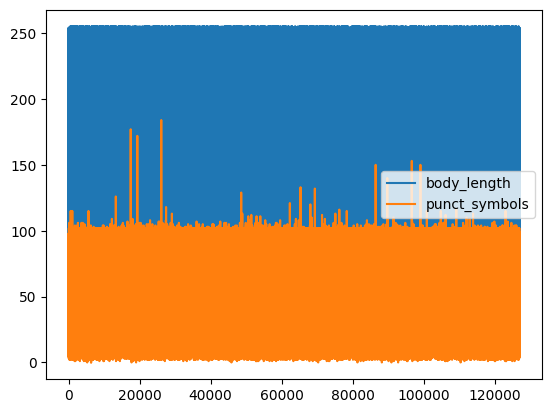

In [5]:
ds['body_length'] = ds['body'].apply(lambda x: len(x))
ds['punct_symbols'] = ds['body'].apply(num_punct_symbols)
ds[['body_length','punct_symbols']].plot(kind='line')
ds['punct_symbols_frac'] = ds['punct_symbols']/ds['body_length']

In [6]:
bots = ds[ds.Y == 0]
not_bots = ds[ds.Y != 0]

<Axes: >

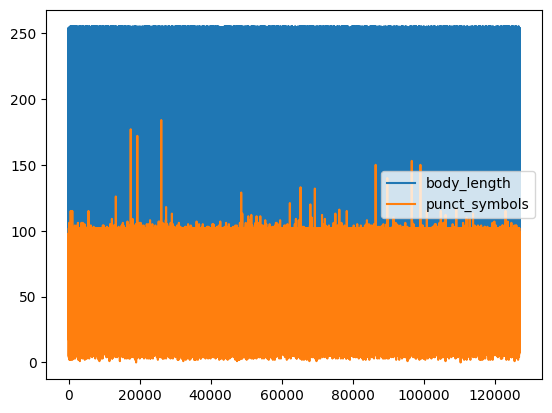

In [7]:
bots[['body_length','punct_symbols']].plot(kind='line')

<Axes: >

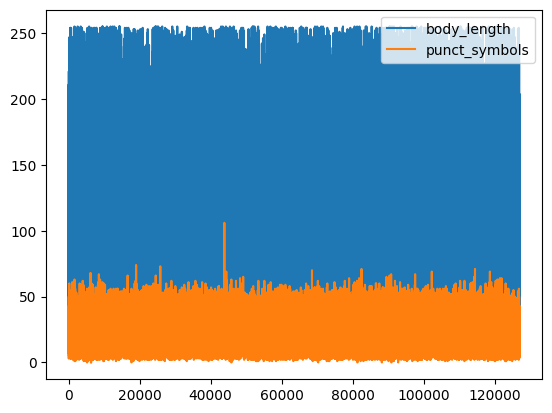

In [8]:
not_bots[['body_length','punct_symbols']].plot(kind='line')

In [9]:
bots = ds[ds.Y == 0].sample(n=5000,random_state=32,ignore_index=True)
not_bots = ds[ds.Y != 0].sample(n=5000,random_state=32,ignore_index=True)

Посмотрим какому закону распределения соответствует сэмпл с ботами. Попробуем нормальное и гамма распределения.

In [10]:
from scipy.stats import norm

In [11]:
stats.shapiro(bots['punct_symbols_frac'])

ShapiroResult(statistic=0.9429059028625488, pvalue=3.017598152030991e-40)

In [12]:
stats.shapiro(not_bots['punct_symbols_frac'])

ShapiroResult(statistic=0.9294557571411133, pvalue=1.6114932339735396e-43)

Данные не имеют нормальнонго распределения.

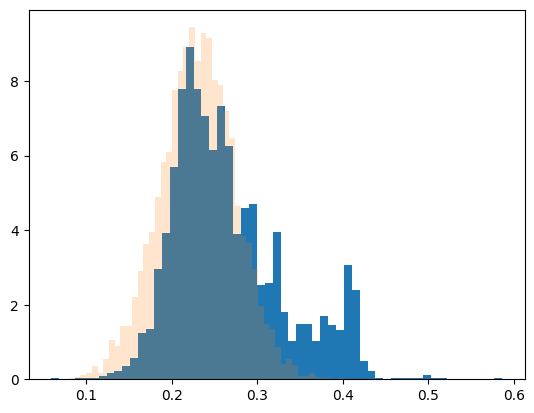

In [13]:
sample = norm.rvs(loc=0.23, scale=1./23, size=5000)
fig, ax = plt.subplots(1, 1)
ax.hist(bots['punct_symbols_frac'], density=True, bins='auto', histtype='stepfilled')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha = 0.2)
plt.show()

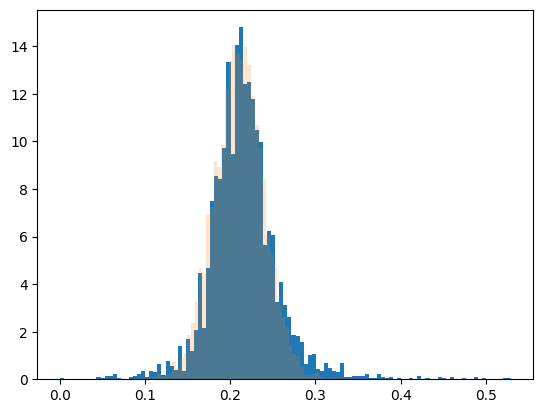

In [14]:
sample = norm.rvs(loc=0.21, scale=1./34, size=5000)
fig, ax = plt.subplots(1, 1)
ax.hist(not_bots['punct_symbols_frac'], density=True, bins='auto', histtype='stepfilled')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha = 0.2)
plt.show()

Т.к. распределение одной из выборок не является нормальным, надо будет выбрать такие тесты, которые не требуют нормально распределенных данных.

Для t-test нормальным должно быть распределение среднего значения метрики в группе, этого достаточно, если сама группа достаточн большая. 

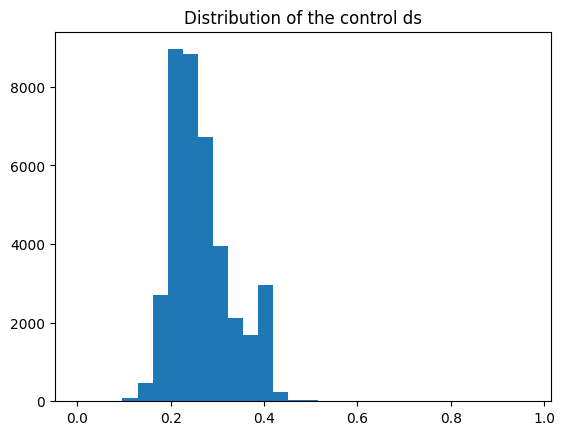

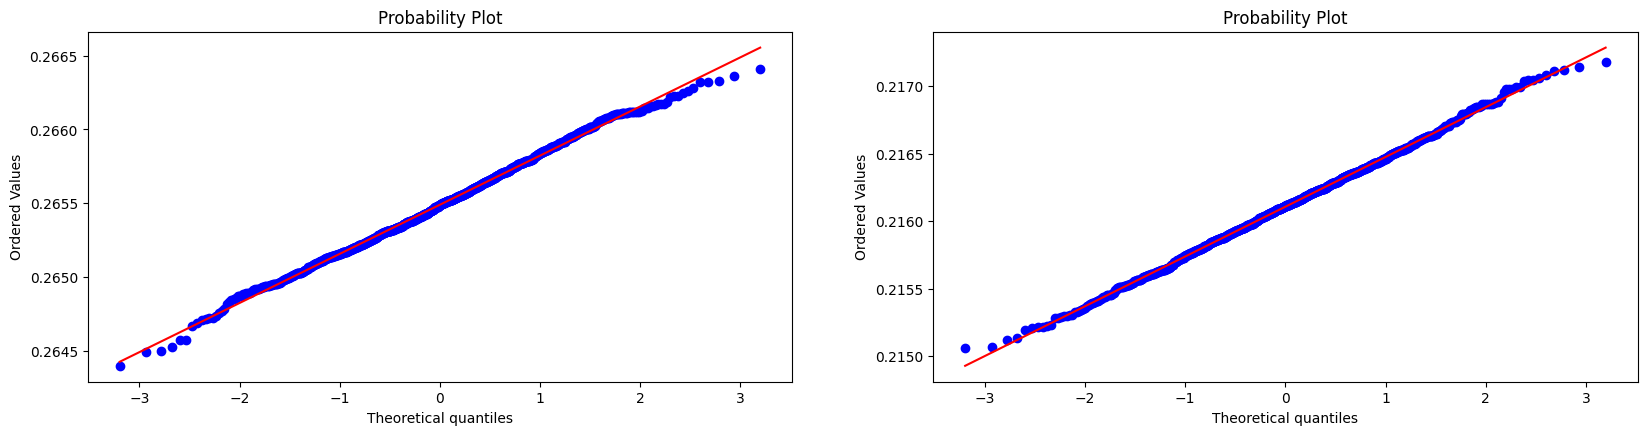

Тест на нормальность распределения control группы: W = 0.997 , p-value = 0.076 => не стат значимо, нормальное
Тест на нормальность распределения target группы: W = 0.999 , p-value = 0.677 => не стат значимо, нормальное


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import pylab
from pylab import *

sample_means_control = []
sample_means_target = []

for i in range(1000):
  sample_control = ds.loc[ds.Y == 0, 'punct_symbols_frac'].sample(frac=0.5, replace=True)
  sample_target = ds.loc[ds.Y != 0, 'punct_symbols_frac'].sample(frac=0.5, replace=True)
  sample_means_control.append(sample_control.mean())
  sample_means_target.append(sample_target.mean())
  
# Plot the population
count, bins, ignored = plt.hist(sample_control, 30)
plt.title('Distribution of the control ds')
plt.show()

# Q-Q plots for control and target groups
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
stats.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(sample_means_target, dist="norm", plot=pylab)
pylab.show()

# check for normality by Shapiro-Wilk test
sp = stats.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(sample_means_target)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)


In [16]:
print('bots_var', np.var(bots['punct_symbols_frac'],ddof =1))

bots_var 0.004273248572259302


In [17]:
print('not_bots_var', np.var(not_bots['punct_symbols_frac'], ddof = 1))

not_bots_var 0.001616844573887593


In [18]:
import scipy.stats as stats

print(stats.levene(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'], center='median'))
print(stats.levene(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'], center='mean'))
print(stats.levene(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'], center='trimmed'))

LeveneResult(statistic=909.113641498639, pvalue=3.128315328792219e-191)
LeveneResult(statistic=1157.7853851340533, pvalue=3.206490386688466e-240)
LeveneResult(statistic=1801.761890875258, pvalue=0.0)


отвергаем 0-гипотезу -> не имеют одинаковую дисперсию

Тест Уэлча

In [19]:
stats.ttest_ind(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'], equal_var=False)

Ttest_indResult(statistic=46.5038961073412, pvalue=0.0)

отвергаем 0-гипотезу -> не имеют одинаковое среднее

Критерий Манна-Уитни

In [20]:
scipy.stats.mannwhitneyu(bots['punct_symbols_frac'], not_bots['punct_symbols_frac'])

MannwhitneyuResult(statistic=18662314.5, pvalue=0.0)

0 < 0.5 => отклоняем H0 => среднее выборок сильно отличаются, они не из одной популяции

In [21]:
pattern = ["<3", "♥",">:D", ":-D", ":D", "=-D", "=D", "X-D", "x-D", "XD", "xD", "8-D", ">:P", ":-P", ":P", ":-p", ":p", ":-b", ":b", ":c\)", ":o\)", ":^\)", ">:\)", ":-\)", ":\)", "=\)", "=]", ":]", ":}", ":>", ":3", "8\)", "8-\)", ">;]", ";-\)", ";\)", ";-]", ";]", ";D", ";^\)", "\*-\)", "\*\)", ">:o", ":-O", ":O", ":o", ":-o", "o_O", "o.O", "°O°", "°o°", ">:/",  ":-/", ":/", ":-.", ":-s", ":s", ":S", ":-S", ">.>", ">:\[", ":-\(", ":\(", "=\(", ":-\[", ":\[", ":{", ":-<", ":c", ":-c", "=/",":'\(", ":'''\(", ";'\(","\(\(\(","\)\)\)"]

def num_smiles(text):
  sum = 0
  for i in pattern:
    sum += len(re.findall(i, text))
  return sum

In [22]:
ds['smile'] = ds['body'].apply(num_smiles)

In [25]:
bots = ds[ds.Y == 0]
trolls = ds[ds.Y == 1]
norms = ds[ds.Y == 2]
not_bots = ds[ds.Y !=0]

In [26]:
print(bots.smile.mean(),trolls.smile.mean(),norms.smile.mean())

1.2929060016231049 0.0931082981715893 0.09145823501651723


In [27]:
print(stats.shapiro(bots.smile))
print(stats.shapiro(not_bots.smile))

ShapiroResult(statistic=0.8439182043075562, pvalue=0.0)
ShapiroResult(statistic=0.3078322410583496, pvalue=0.0)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Данные не имеют нормального распределения

In [28]:
import scipy.stats as stats

print(stats.levene(bots.smile, not_bots.smile, center='median'))
print(stats.levene(bots.smile, not_bots.smile, center='mean'))
print(stats.levene(bots.smile, not_bots.smile, center='trimmed'))

LeveneResult(statistic=21890.249825027367, pvalue=0.0)
LeveneResult(statistic=30705.228711825595, pvalue=0.0)
LeveneResult(statistic=39048.4622559279, pvalue=0.0)


Дисперсии различны

Тест Уелча

In [29]:
stats.ttest_ind(bots.smile, not_bots.smile, equal_var=False)

Ttest_indResult(statistic=234.04090902501144, pvalue=0.0)

Критерий Манна -Уитни

In [30]:
stats.mannwhitneyu(bots.smile, not_bots.smile)

MannwhitneyuResult(statistic=1537341340.0, pvalue=0.0)

0 < 0.5 => отклоняем H0 => среднее выборок сильно отличаются, они не из одной популяции